In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from joblib import Parallel, delayed
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from ydata_profiling import ProfileReport

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
warnings.filterwarnings("ignore")

## Importing Data sets

In [3]:
df = pd.read_feather("D:/Internship/Training Week 01/Assignment 01/Final_Code/train_data.ftr")
labels = pd.read_csv("D:/Internship/Training Week 01/Assignment 01/Final_Code/train_labels.csv")
sample_submission = pd.read_csv("D:/Internship/Training Week 01/Assignment 01/Final_Code/sample_submission.csv")
test_data = pd.read_feather("D:/Internship/Training Week 01/Assignment 01/Final_Code/test_data.ftr")

## Exploratory Data Analysis

In [4]:
df = df.head(100000)
df.head()

customer_ID         S_2       P_2  \
0  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-03-09  0.938477   
1  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-04-07  0.936523   
2  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-05-28  0.954102   
3  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-06-13  0.960449   
4  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-07-16  0.947266   

       D_39       B_1       B_2       R_1       S_3      D_41       B_3  ...  \
0  0.001734  0.008728  1.006836  0.009224  0.124023  0.008774  0.004707  ...   
1  0.005775  0.004925  1.000977  0.006153  0.126709  0.000798  0.002714  ...   
2  0.091492  0.021652  1.009766  0.006817  0.123962  0.007599  0.009422  ...   
3  0.002455  0.013687  1.002930  0.001372  0.117188  0.000685  0.005531  ...   
4  0.002483  0.015190  1.000977  0.007607  0.117310  0.004654  0.009308  ...   

   D_136  D_137  D_138     D_139     D_140     D_141  D_142     D_143  \
0    NaN    NaN    NaN  0.002426  0.003706  0.003819    NaN  0.000569   
1    NaN    NaN    NaN  0.003956  0.003166  0.005032    NaN  0.009575   
2    NaN    NaN    NaN  0.003269  0.007328  0.000427    NaN  0.003429   
3    NaN    NaN    NaN  0.006119  0.004517  0.003201    NaN  0.008423   
4    NaN    NaN    NaN  0.003672  0.004944  0.008888    NaN  0.001670   

      D_144     D_145  
0  0.000610  0.002674  
1  0.005493  0.009216  
2  0.006985  0.002604  
3  0.006527  0.009598  
4  0.008125  0.009827  

[5 rows x 190 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 190 entries, customer_ID to D_145
dtypes: category(11), float16(176), int64(1), object(2)
memory usage: 36.9+ MB


In [6]:
df.describe()

P_2          D_39            B_1           B_2            R_1  \
count  99214.000000  1.000000e+05  100000.000000  99963.000000  100000.000000   
mean       0.000000  0.000000e+00       0.000000      0.000000       0.000000   
std        0.246704  2.741699e-01       0.214966      0.402100       0.231079   
min       -0.383057  8.940697e-07      -0.295166      0.000003       0.000000   
25%        0.476074  4.566193e-03       0.008942      0.102051       0.002886   
50%        0.692383  9.124756e-03       0.032471      0.813965       0.005787   
75%        0.863770  2.368164e-01       0.129028      1.001953       0.008669   
max        1.009766  5.332031e+00       1.324219      1.009766       2.507812   

                S_3          D_41           B_3          D_42          D_43  \
count  81374.000000  9.996300e+04  9.996300e+04  14614.000000  6.980500e+04   
mean       0.000000  0.000000e+00  0.000000e+00      0.183105  0.000000e+00   
std        0.197632  2.087402e-01  2.348633e-01      0.232300  2.249756e-01   
min       -0.254639  5.960464e-08  4.172325e-07     -0.000219  8.940697e-07   
25%        0.126953  2.916336e-03  5.332947e-03      0.037689  4.223633e-02   
50%        0.163818  5.798340e-03  9.941101e-03      0.121948  8.813477e-02   
75%        0.258545  8.705139e-03  1.612549e-01      0.249634  1.854248e-01   
max        2.917969  5.464844e+00  1.401367e+00      3.251953  9.085938e+00   

       ...        D_136        D_137        D_138         D_139         D_140  \
count  ...  3616.000000  3616.000000  3616.000000  9.818700e+04  9.927400e+04   
mean   ...     0.240967     0.016418     0.173950  0.000000e+00  0.000000e+00   
std    ...     0.208374     0.105957     0.268555  3.808594e-01  1.436768e-01   
min    ...     0.000001     0.000001     0.000008  4.172325e-07  2.980232e-07   
25%    ...     0.008804     0.002636     0.003704  3.021240e-03  2.555847e-03   
50%    ...     0.253906     0.005180     0.007187  6.053925e-03  5.115509e-03   
75%    ...     0.258545     0.007694     0.501953  9.109497e-03  7.675171e-03   
max    ...     1.505859     1.009766     1.507812  1.009766e+00  1.009766e+00   

              D_141         D_142         D_143         D_144         D_145  
count  9.818700e+04  17272.000000  98187.000000  9.926700e+04  9.818700e+04  
mean   0.000000e+00      0.395996      0.000000  0.000000e+00  0.000000e+00  
std    3.505859e-01      0.241821      0.380615  1.888428e-01  1.983643e-01  
min    5.960464e-08     -0.014442      0.000000  1.192093e-07  5.960464e-08  
25%    3.030777e-03      0.197754      0.003017  2.754211e-03  3.046036e-03  
50%    6.061554e-03      0.385254      0.006073  5.508423e-03  6.061554e-03  
75%    9.094238e-03      0.568359      0.009087  8.277893e-03  9.094238e-03  
max    1.174805e+00      1.750977      1.009766  1.343750e+00  4.281250e+00  

[8 rows x 177 columns]

In [7]:
df.nunique()

customer_ID     8294
S_2              396
P_2             5181
D_39            8463
B_1            12031
               ...  
D_141           7046
D_142           4856
D_143           6678
D_144          10450
D_145           7288
Length: 190, dtype: int64

In [8]:
df.dtypes

customer_ID     object
S_2             object
P_2            float16
D_39           float16
B_1            float16
                ...   
D_141          float16
D_142          float16
D_143          float16
D_144          float16
D_145          float16
Length: 190, dtype: object

In [9]:
df.head()

customer_ID         S_2       P_2  \
0  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-03-09  0.938477   
1  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-04-07  0.936523   
2  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-05-28  0.954102   
3  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-06-13  0.960449   
4  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-07-16  0.947266   

       D_39       B_1       B_2       R_1       S_3      D_41       B_3  ...  \
0  0.001734  0.008728  1.006836  0.009224  0.124023  0.008774  0.004707  ...   
1  0.005775  0.004925  1.000977  0.006153  0.126709  0.000798  0.002714  ...   
2  0.091492  0.021652  1.009766  0.006817  0.123962  0.007599  0.009422  ...   
3  0.002455  0.013687  1.002930  0.001372  0.117188  0.000685  0.005531  ...   
4  0.002483  0.015190  1.000977  0.007607  0.117310  0.004654  0.009308  ...   

   D_136  D_137  D_138     D_139     D_140     D_141  D_142     D_143  \
0    NaN    NaN    NaN  0.002426  0.003706  0.003819    NaN  0.000569   
1    NaN    NaN    NaN  0.003956  0.003166  0.005032    NaN  0.009575   
2    NaN    NaN    NaN  0.003269  0.007328  0.000427    NaN  0.003429   
3    NaN    NaN    NaN  0.006119  0.004517  0.003201    NaN  0.008423   
4    NaN    NaN    NaN  0.003672  0.004944  0.008888    NaN  0.001670   

      D_144     D_145  
0  0.000610  0.002674  
1  0.005493  0.009216  
2  0.006985  0.002604  
3  0.006527  0.009598  
4  0.008125  0.009827  

[5 rows x 190 columns]

In [10]:
null_counts = df.isna().sum()
null_counts = null_counts[null_counts > 0]

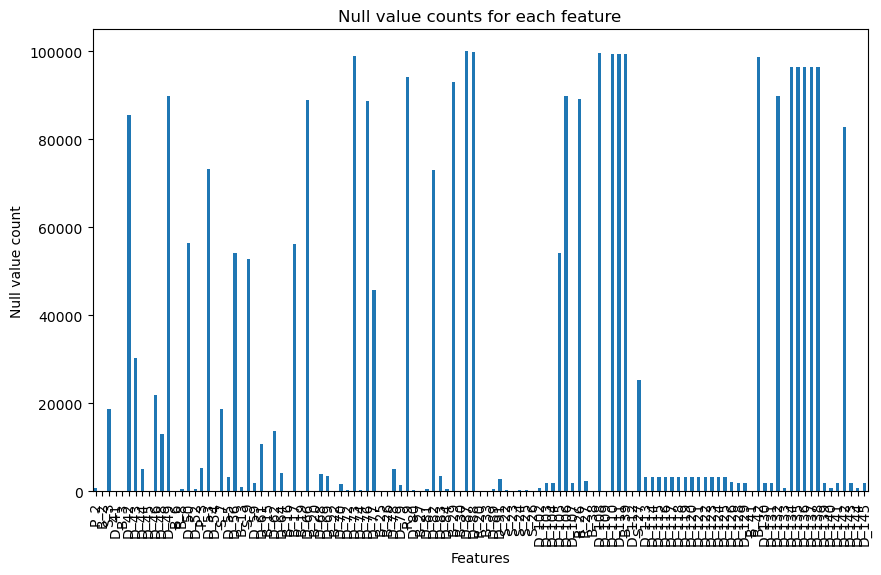

In [11]:
plt.figure(figsize=(10,6))
null_counts.plot(kind = "bar")
plt.title("Null value counts for each feature")
plt.xlabel("Features")
plt.ylabel("Null value count")
plt.xticks(rotation=90)
plt.show()

In [12]:
categorical_feature_names = df.select_dtypes(include=['category']).columns.tolist()

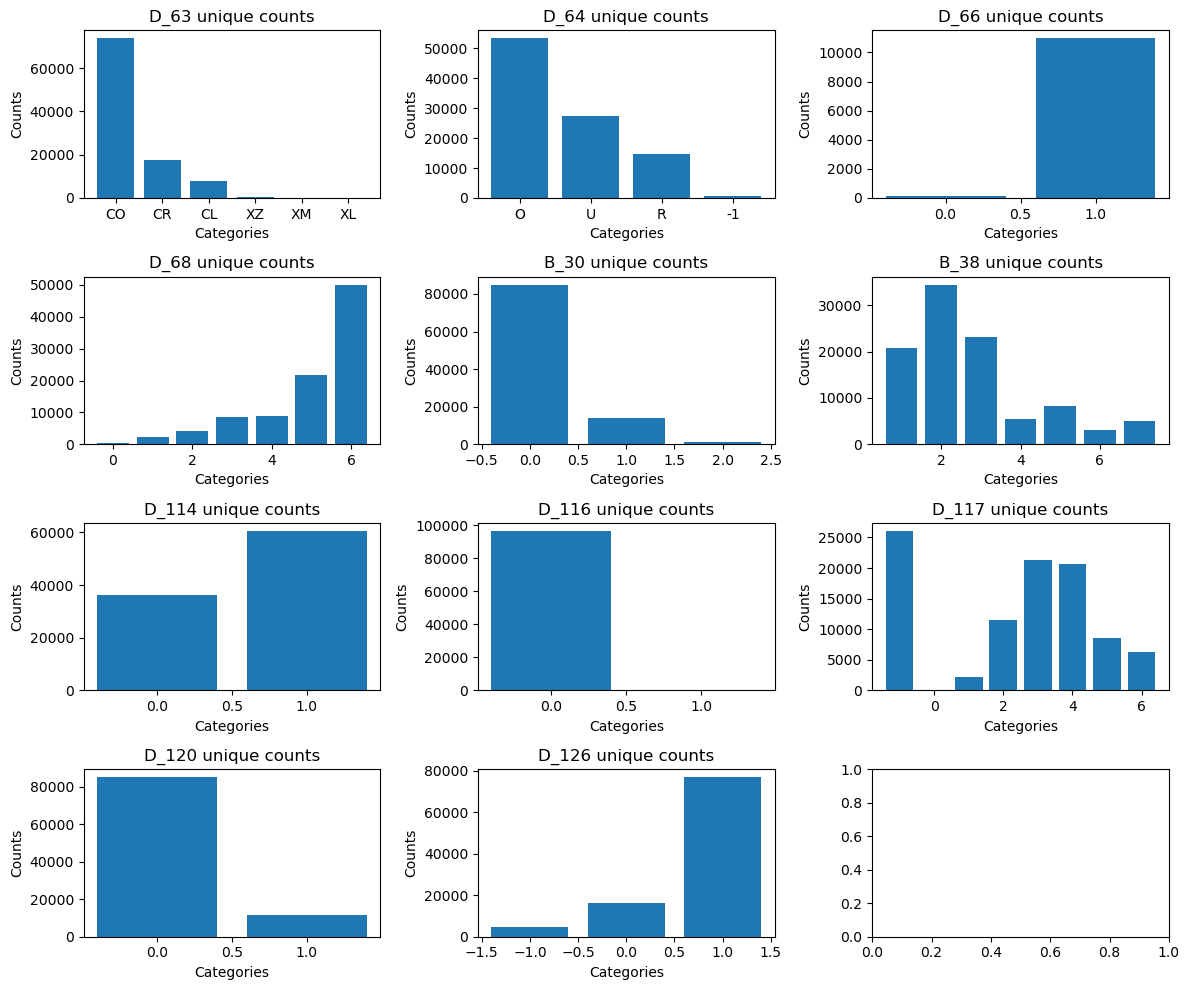

In [13]:
fig, axes = plt.subplots(4,3,figsize=(12,10))

for i, categorical_feature in enumerate(categorical_feature_names):
    row = i // 3
    col = i % 3
    ax = axes[row,col]
    ax.bar(df[categorical_feature].value_counts().index, df[categorical_feature].value_counts().values)
    ax.set_title(f'{categorical_feature} unique counts')
    ax.set_xlabel("Categories")
    ax.set_ylabel("Counts")
    

plt.tight_layout()
plt.show()

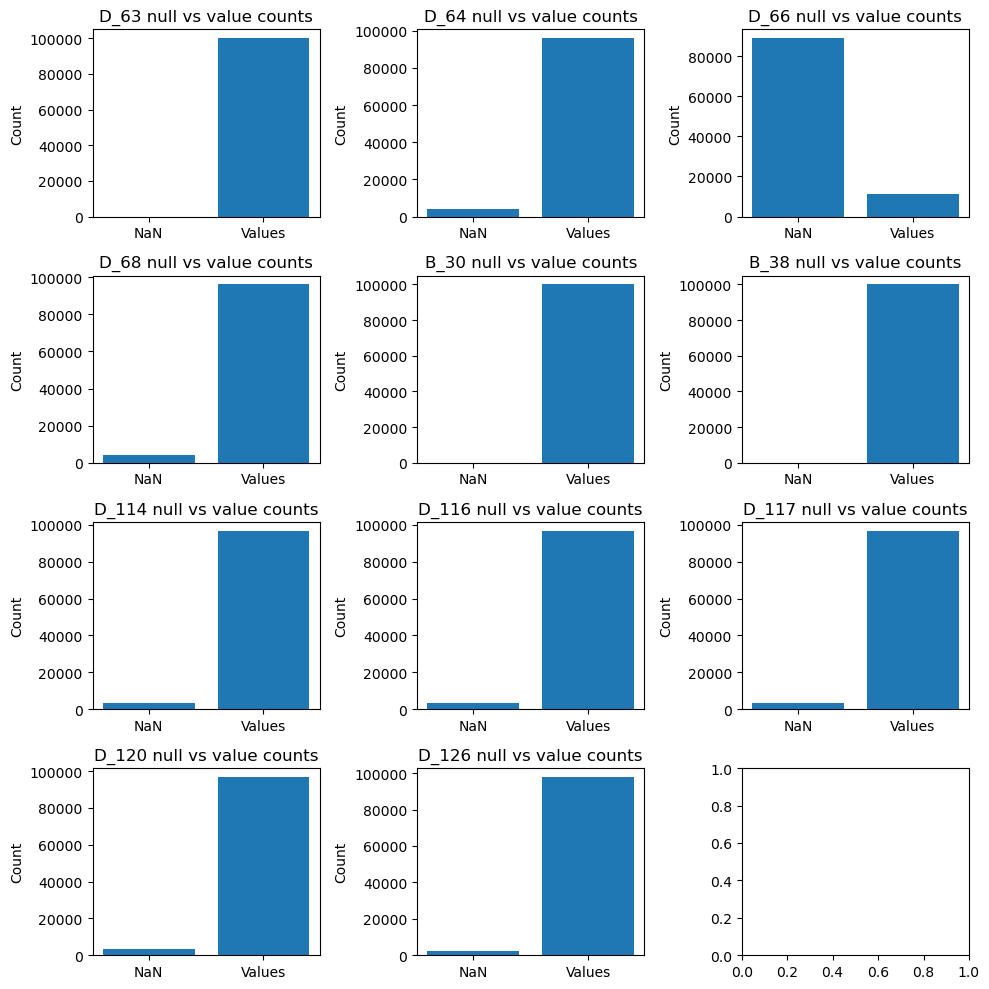

In [14]:
fig, axes = plt.subplots(4, 3, figsize=(10, 10))

for i, categorical_feature in enumerate(categorical_feature_names):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.bar(["NaN","Values"], [df[categorical_feature].isna().sum(),df[categorical_feature].value_counts().sum()])
    ax.set_title(f'{categorical_feature} null vs value counts')
    ax.set_ylabel("Count")
    

plt.tight_layout()
plt.show()

## Handling Missing Values

In [15]:
def impute_categorical_features(df):
    # Impute using 'O' because 'O' has most number of occurences
    df['D_64'].fillna('O', inplace=True)
    # Drop the column because most of the values are NaN
    df.drop('D_66', axis=1, inplace=True)
    # Impute using '6.0' because '6.0' has most number of occurences 
    df['D_68'].fillna(6.0,inplace=True)
    # Impute using 2.0, introduced new category for NaN values
    df['D_114'] = np.where(df['D_114'].isnull(), 2.0, df['D_114'])
    # Impute using 0.0 because 0.0 has most number of occurences
    df['B_30'].fillna(0.0,inplace=True)
    # Impute using 8.0, introduced new category for NaN values
    df['B_38'] = np.where(df['B_38'].isnull(), 2.0, df['B_38'])
    # Impute using 0.0 because 0.0 has most number of occurences
    df['D_116'].fillna(0.0,inplace=True)
    # Impute using 7.0, introduced new category for NaN values
    df['D_117'] = np.where(df['D_117'].isnull(), 2.0, df['D_117'])
    # Impute using 0.0 because 0.0 has most number of occurences
    df['D_120'].fillna(0.0,inplace=True)
    # Impute using 1.0 because 1.0 has most number of occurences
    df['D_126'].fillna(1.0,inplace=True)
    return df

In [16]:
df = impute_categorical_features(df)

In [17]:
categorical_feature_names.remove('D_66')

In [18]:
labelEncoder = LabelEncoder()

for index, categorical_feature in enumerate(categorical_feature_names):
    df[categorical_feature] = labelEncoder.fit_transform(df[categorical_feature])

In [19]:
df_length = len(df)
dropped_cols = []

for i, col in enumerate(df.columns):
    null_percentage = df[col].isna().sum()/df_length*100
    if null_percentage > 50.0:
        df.drop(col,axis=1,inplace=True)
        dropped_cols.append(col)

In [20]:
new_null_counts = df.isna().sum()
new_null_counts = new_null_counts[new_null_counts>0]

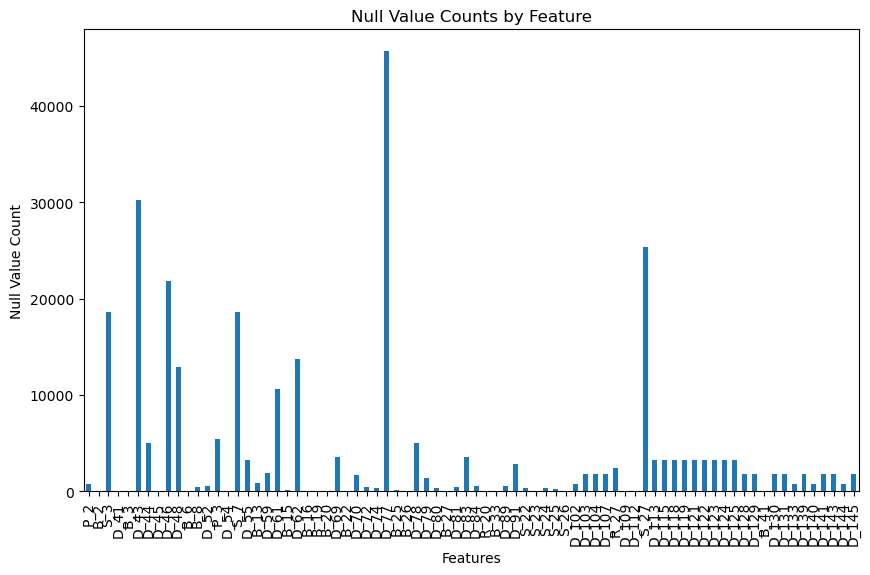

In [21]:
plt.figure(figsize = (10,6))
new_null_counts.plot(kind="bar")
plt.title('Null Value Counts by Feature')
plt.xlabel('Features')
plt.ylabel('Null Value Count')
plt.xticks(rotation=90) 
plt.show()

In [22]:
def prepare_duration_feature(df):
    df['S_2'] = pd.to_datetime(df['S_2'])
    df.sort_values(by=['customer_ID','S_2'],inplace=True)
    df['duration'] = df.groupby('customer_ID')['S_2'].diff().dt.days
    df['duration'].fillna(0,inplace=True)
    df.drop('S_2', axis=1, inplace=True)
    return df

In [23]:
df = prepare_duration_feature(df)

In [24]:
def fill_missing_with_customer_mean(customer_id):
    customer_group = df[df['customer_ID'] == customer_id]
    customer_mean = customer_group.drop(columns='customer_ID').mean()
    customer_group = customer_group.fillna(customer_mean)
    return customer_group

In [25]:
unique_customer_ids = df['customer_ID'].unique()

num_workers = 4

filled_customer_data = Parallel(n_jobs=num_workers)(delayed(fill_missing_with_customer_mean)(customer_id) for customer_id in unique_customer_ids)

df = pd.concat(filled_customer_data)

In [26]:
num_features = df.shape[1]
num_rows = (num_features // 3) + (num_features % 3 > 0)  
num_cols = 3

In [27]:
correlation_matrix = df.drop("customer_ID",axis=1).corr()
correlation_matrix


P_2      D_39       B_1       B_2       R_1       S_3  \
P_2       1.000000 -0.200801 -0.362045  0.539034 -0.469439 -0.334238   
D_39     -0.200801  1.000000  0.178517 -0.196072  0.201701  0.061253   
B_1      -0.362045  0.178517  1.000000 -0.624452  0.218704  0.147183   
B_2       0.539034 -0.196072 -0.624452  1.000000 -0.299968 -0.225863   
R_1      -0.469439  0.201701  0.218704 -0.299968  1.000000  0.205267   
...            ...       ...       ...       ...       ...       ...   
D_141    -0.178846  0.033979  0.104699 -0.153887  0.080733  0.047312   
D_143    -0.183617  0.033993  0.107177 -0.156533  0.082230  0.050062   
D_144    -0.000075  0.006671  0.024565 -0.048964  0.012088 -0.010262   
D_145    -0.161108  0.032909  0.089762 -0.128911  0.076044  0.035878   
duration  0.001175  0.017173  0.003918 -0.021883  0.022482  0.004446   

              D_41       B_3      D_43      D_44  ...     D_131     D_133  \
P_2      -0.324097 -0.443708 -0.290575 -0.571778  ... -0.210535 -0.137251   
D_39      0.450973  0.168974  0.042796  0.138775  ...  0.058724  0.039838   
B_1       0.197554  0.719628  0.045190  0.312123  ...  0.132018  0.102391   
B_2      -0.261400 -0.712777 -0.117583 -0.447620  ... -0.200765 -0.148254   
R_1       0.280581  0.263904  0.173100  0.396230  ...  0.137334  0.097092   
...            ...       ...       ...       ...  ...       ...       ...   
D_141     0.053231  0.132820  0.058216  0.137973  ...  0.127519  0.072448   
D_143     0.053521  0.135141  0.060968  0.139905  ...  0.128473  0.073429   
D_144     0.008735  0.044729 -0.011221  0.030312  ...  0.059612  0.041020   
D_145     0.054540  0.118902  0.052368  0.117780  ...  0.072150  0.041698   
duration  0.020588  0.026979 -0.007586  0.012314  ...  0.000605  0.004479   

              R_28     D_139     D_140     D_141     D_143     D_144  \
P_2      -0.018923 -0.183545 -0.139557 -0.178846 -0.183617 -0.000075   
D_39     -0.002652  0.033962  0.031209  0.033979  0.033993  0.006671   
B_1       0.061794  0.107221  0.041130  0.104699  0.107177  0.024565   
B_2      -0.021888 -0.156286 -0.087558 -0.153887 -0.156533 -0.048964   
R_1       0.037246  0.082050  0.064833  0.080733  0.082230  0.012088   
...            ...       ...       ...       ...       ...       ...   
D_141     0.021771  0.998072  0.317053  1.000000  0.997299  0.605314   
D_143     0.023204  0.999181  0.315902  0.997299  1.000000  0.578003   
D_144    -0.004398  0.578359 -0.039289  0.605314  0.578003  1.000000   
D_145     0.014964  0.630695  0.201479  0.616788  0.630918  0.218053   
duration -0.006379 -0.005291  0.002592 -0.005067 -0.005345 -0.000420   

             D_145  duration  
P_2      -0.161108  0.001175  
D_39      0.032909  0.017173  
B_1       0.089762  0.003918  
B_2      -0.128911 -0.021883  
R_1       0.076044  0.022482  
...            ...       ...  
D_141     0.616788 -0.005067  
D_143     0.630918 -0.005345  
D_144     0.218053 -0.000420  
D_145     1.000000 -0.005411  
duration -0.005411  1.000000  

[159 rows x 159 columns]

## Exploring Outliers

In [28]:
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(25, 4*num_rows))
axes = axes.flatten()

for i, col in enumerate(df.drop("customer_ID",axis = 1).columns):
    axes[i].hist(df[col], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    
plt.tight_layout()
plt.show()

In [29]:
num_features = df.shape[1]
num_rows = (num_features // 2) + (num_features % 2 > 0)  
num_cols = 2

In [30]:
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(30, 4*num_rows))
axes = axes.flatten()

for i, col in enumerate(df.drop("customer_ID",axis = 1).columns):
    axes[i].boxplot(df[col], vert=False)
    axes[i].set_title(col)
    
plt.tight_layout()
plt.show()

## Handling Outliers using zscore

In [31]:
def handle_outliers(df, threshold=3):
    z_scores = zscore(df)
    outliers = (np.abs(z_scores) > threshold).any(axis = 1)
    cleaned_data = df[~outliers]
    return cleaned_data

In [32]:
feature_means = df.drop('customer_ID', axis= 1).mean()
df = df.fillna(feature_means)

In [33]:
null_check = df.isna().sum()
null_check = null_check[null_check > 0]
null_check

D_54        1
S_22        1
S_24        1
R_27     2278
D_112       1
dtype: int64

In [34]:
merged_df = pd.merge(df,labels,on='customer_ID',how='inner')
merged_df.dropna(inplace=True)

In [35]:
merged_df = handle_outliers(merged_df.drop("customer_ID", axis=1))

In [36]:
X = merged_df.drop(columns=['target'])
y = merged_df['target']

## Handing data imbalances using under-sampling method.

In [37]:
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X,y = under_sampler.fit_resample(X,y)

## Train, Test split.

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)

## Validation data set preparation using sample_submission.csv

In [39]:
merged_test = pd.merge(sample_submission, test_data, on="customer_ID",how="inner")
merged_test = merged_test.head(100000)

In [40]:
for column in dropped_cols:
    merged_test.drop(column,axis = 1,inplace=True)

In [41]:
merged_test = prepare_duration_feature(merged_test)

In [42]:
merged_test = impute_categorical_features(merged_test)

In [43]:
for index,categorical_feature in enumerate(categorical_feature_names):
    merged_test[categorical_feature] = labelEncoder.fit_transform(merged_test[categorical_feature])

In [44]:
columns = X.columns

test_labels = merged_test['prediction']
merged_test = merged_test[columns]

In [45]:
merged_test.head()

P_2      D_39       B_1       B_2       R_1       S_3      D_41  \
0  0.631348  0.001912  0.010727  0.814453  0.007545  0.168701  0.009972   
1  0.586914  0.005276  0.011024  0.811035  0.001817  0.241333  0.000166   
2  0.608887  0.003326  0.016388  1.004883  0.000114  0.267090  0.004196   
3  0.614746  0.009064  0.021667  0.816406  0.009720  0.188965  0.004124   
4  0.591797  0.238770  0.015930  0.810547  0.002026  0.180054  0.000731   

        B_3  D_43      D_44  ...     D_131     D_133      R_28     D_139  \
0  0.002348   NaN  0.007584  ...       NaN  0.007080  0.005959       NaN   
1  0.009132   NaN  0.006645  ...  0.008072  0.007187  0.001253  0.000142   
2  0.004192   NaN  0.009605  ...  0.009865  0.008438  0.001924  0.000074   
3  0.015327   NaN  0.007820  ...  0.005898  0.002422  0.006756  0.004742   
4  0.011284   NaN  0.009956  ...  0.005310  0.000302  0.003578  0.008133   

      D_140     D_141     D_143     D_144     D_145  duration  
0  0.004669       NaN       NaN  0.008278       NaN       0.0  
1  0.004940  0.009018  0.003695  0.003754  0.001460      34.0  
2  0.002113  0.004658  0.003155  0.002155  0.006481      31.0  
3  0.006393  0.002890  0.006042  0.005207  0.007858      25.0  
4  0.004330  0.008385  0.001008  0.007420  0.009468      26.0  

[5 rows x 159 columns]

In [46]:
imputer = SimpleImputer(strategy='mean')
imputer.fit(X)
test_imputed = imputer.transform(merged_test)

In [47]:
def build_confusion_matrix(labels, preds):
    return confusion_matrix(labels,preds)

In [48]:
def build_classification_report(labels, preds):
    return classification_report(labels,preds)

In [49]:
def plot_confusion_matrix(matrix,heading):
    plt.figure(figsize=(4,3))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 12})
    plt.title(heading)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## Random Forest Classifier 

In [50]:
clf = RandomForestClassifier(max_depth=20, random_state=0)
clf.fit(X_train,y_train)

RandomForestClassifier(max_depth=20, random_state=0)

In [51]:
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

In [52]:
test_conf_matrix = build_confusion_matrix(y_test,predict_test)
print(test_conf_matrix)

[[848 118]
 [ 81 959]]


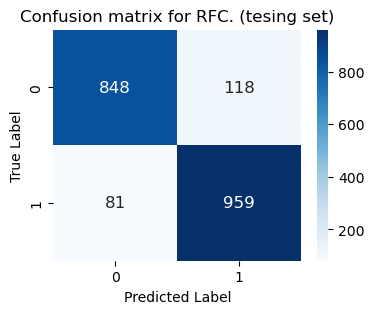

In [53]:
plot_confusion_matrix(test_conf_matrix,"Confusion matrix for RFC. (tesing set)")

In [54]:
print(build_classification_report(y_test,predict_test))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89       966
           1       0.89      0.92      0.91      1040

    accuracy                           0.90      2006
   macro avg       0.90      0.90      0.90      2006
weighted avg       0.90      0.90      0.90      2006



In [55]:
print(build_confusion_matrix(y_train,predict_train))

[[2374    3]
 [   0 2303]]


In [56]:
print(build_classification_report(y_train,predict_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2377
           1       1.00      1.00      1.00      2303

    accuracy                           1.00      4680
   macro avg       1.00      1.00      1.00      4680
weighted avg       1.00      1.00      1.00      4680



In [57]:
predict_validation = clf.predict(test_imputed)
print(build_confusion_matrix(test_labels,predict_validation))

[[59203 40797]
 [    0     0]]


In [58]:
print(build_classification_report(test_labels,predict_validation))

              precision    recall  f1-score   support

           0       1.00      0.59      0.74    100000
           1       0.00      0.00      0.00         0

    accuracy                           0.59    100000
   macro avg       0.50      0.30      0.37    100000
weighted avg       1.00      0.59      0.74    100000



## XGBoost Classifier

In [59]:
xgb = XGBClassifier(random_state = 8)
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=8, ...)

In [60]:
predict_train = xgb.predict(X_train)
predict_test = xgb.predict(X_test)

In [61]:
test_conf_matrix = build_confusion_matrix(y_test,predict_test)
print(test_conf_matrix)

[[861 105]
 [ 58 982]]


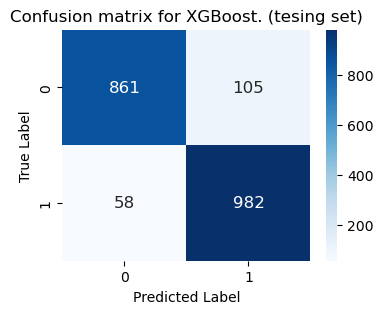

In [62]:
plot_confusion_matrix(test_conf_matrix,"Confusion matrix for XGBoost. (tesing set)")

In [63]:
print(build_classification_report(y_test,predict_test))

              precision    recall  f1-score   support

           0       0.94      0.89      0.91       966
           1       0.90      0.94      0.92      1040

    accuracy                           0.92      2006
   macro avg       0.92      0.92      0.92      2006
weighted avg       0.92      0.92      0.92      2006



In [64]:
print(build_confusion_matrix(y_train,predict_train))

[[2377    0]
 [   0 2303]]


In [65]:
print(build_classification_report(y_train,predict_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2377
           1       1.00      1.00      1.00      2303

    accuracy                           1.00      4680
   macro avg       1.00      1.00      1.00      4680
weighted avg       1.00      1.00      1.00      4680



In [66]:
predict_validation = xgb.predict(test_imputed)
print(build_confusion_matrix(test_labels,predict_validation))

[[59837 40163]
 [    0     0]]


In [67]:
print(build_classification_report(test_labels,predict_validation))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75    100000
           1       0.00      0.00      0.00         0

    accuracy                           0.60    100000
   macro avg       0.50      0.30      0.37    100000
weighted avg       1.00      0.60      0.75    100000



## SVM Classifier

In [68]:
clf_svm = svm.SVC(gamma=0.001)
clf_svm.fit(X_train,y_train)

SVC(gamma=0.001)

In [69]:
predict_train = clf_svm.predict(X_train)
predict_test = clf_svm.predict(X_test)

In [70]:
test_conf_matrix = build_confusion_matrix(y_test,predict_test)
print(test_conf_matrix)

[[817 149]
 [140 900]]


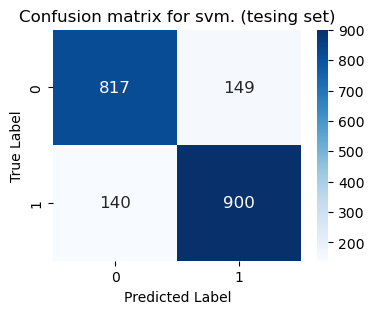

In [71]:
plot_confusion_matrix(test_conf_matrix,"Confusion matrix for svm. (tesing set)")

In [72]:
print(build_classification_report(y_test,predict_test))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       966
           1       0.86      0.87      0.86      1040

    accuracy                           0.86      2006
   macro avg       0.86      0.86      0.86      2006
weighted avg       0.86      0.86      0.86      2006



In [73]:
print(build_confusion_matrix(y_train,predict_train))

[[1980  397]
 [ 310 1993]]


In [74]:
print(build_classification_report(y_train,predict_train))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      2377
           1       0.83      0.87      0.85      2303

    accuracy                           0.85      4680
   macro avg       0.85      0.85      0.85      4680
weighted avg       0.85      0.85      0.85      4680



In [75]:
predict_validation = clf_svm.predict(test_imputed)
print(build_confusion_matrix(test_labels,predict_validation))

[[57287 42713]
 [    0     0]]


In [76]:
print(build_classification_report(test_labels,predict_validation))

              precision    recall  f1-score   support

           0       1.00      0.57      0.73    100000
           1       0.00      0.00      0.00         0

    accuracy                           0.57    100000
   macro avg       0.50      0.29      0.36    100000
weighted avg       1.00      0.57      0.73    100000



## Predict for the whole test_data set

In [77]:
test_copy = test_data
for column in dropped_cols:
    test_copy.drop(column,axis = 1,inplace=True)

In [78]:
test_copy = prepare_duration_feature(test_copy)

In [79]:
test_copy = impute_categorical_features(test_copy)

In [80]:
for index,categorical_feature in enumerate(categorical_feature_names):
    test_copy[categorical_feature] = labelEncoder.fit_transform(test_copy[categorical_feature])

In [83]:
# test_copy_imputed = imputer.transform(test_copy.drop("customer_ID",axis=1))